## Main Project - Creating an index of labor demand

In this notebook, we use Json-files containing job ads between 2006 - 2019 downloaded through the initiative [Jobtech](https://jobtechdev.se/). After some cleaning, this data is then queried through an SQlite repository. Finally, an index of labor demand is created and used for further analysis.

The analysis can be split into three parts:
 - Checking trend and seasonal components using LOESS
 - Checking Cointegration level using Engle-Granger test
 - Examining relation with Statistics Sweden's quarterly survey of Labor Demand using OLS
 
Finally, the index will be broken down by demand per city and analyzed further.

In [61]:
import json
import csv
import pandas as pd
import sqlite3
import numpy as np
import calendar
from calendar import monthrange
import matplotlib.pyplot as plt

In [30]:
# This function harmonizes citiy names for comparability
# Some rows have '--' and '.' as city and by using len statment we convert these to nan
def correct(x):
    try:
        if len(x) <= 2:
            return np.nan
        else:
            return x.lower()
    except:
        return np.nan

### Converting and cleaning Json-files

The files downloaded through Jobtech are in Json-format. The first step is therefore to transform these into CSV-files more suitable for SQlite. In this process they are also cleaned from aberrations especially in the City-column.

In [23]:
%%time
#Extracting variables of interest and saving as CSV
for i in range(2008,2017):
    
    filename = "/Users/wilhelmakesson/Desktop/Master Thesis/Data/{}.json".format(i) 
    with open(filename) as f:
        ads = json.load(f)
        new_list = []
    for ad in ads:
        try:
            x = [ad['headline'], ad['number_of_vacancies'], ad['publication_date'], ad['application_deadline'], ad['workplace_address']['city']]
            new_list.append(x)
        except:
            x = [ad['headline'], ad['number_of_vacancies'], ad['publication_date'], ad['application_deadline'], np.nan]
            new_list.append(x)
    
    #Harmonizing the city column
    test['city'] = test['city'].apply(lambda x:correct(x))
    test = pd.DataFrame(new_list, columns=('headline','number_of_vacancies', 'publication_date', 'application_deadline', 'city'))
    test.to_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/{}.csv".format(i), index_label=True, encoding='utf-8')

CPU times: user 1min 10s, sys: 2min 50s, total: 4min
Wall time: 14min 20s


In [ ]:
#Channel CSV-files into Sqlite


### Query SQlite
The files have now been channeled through an SQlite database. This enables us to efficiently query the amount of active job ads, meaning ads that have passed publication date but not applicaiton deadline a certain date.

In [110]:
#This establishes a connection to local SQlite Database
conn = sqlite3.connect("/Users/wilhelmakesson/Desktop/Master Thesis/Data/Jobads.db")
cursor = conn.cursor()
columns = []

#Finding the number of Active ads per given time period
for j in range(1,13):
    for i in range(1, calendar.monthrange(2006, j)[1]+1):
        if i < 10 and j < 10:
            query = f"SELECT SUM(number_of_vacancies) FROM ads_2006 WHERE '2006-0{j}-0{i}' >= publication_date AND '2006-0{j}-0{i}' <= application_deadline;"
        elif j < 10 and i >9:
            query = f"SELECT SUM(number_of_vacancies) FROM ads_2006 WHERE '2006-0{j}-{i}' >= publication_date AND '2006-0{j}-{i}' <= application_deadline;"
        elif i < 10 and j >9:
            query = f"SELECT SUM(number_of_vacancies) FROM ads_2006 WHERE '2006-{j}-0{i}' >= publication_date AND '2006-{j}-0{i}' <= application_deadline;"
        else:
            query = f"SELECT SUM(number_of_vacancies) FROM ads_2006 WHERE '2006-{j}-{i}' >= publication_date AND '2006-{j}-{i}' <= application_deadline;"

        data = cursor.execute(query).fetchone()
        ads_per_day = [f'2006-{j}-{i}', data[0]]
        columns.append(ads_per_day)

conn.close()
columns

[['2006-1-1', 74],
 ['2006-1-2', 1103],
 ['2006-1-3', 2487],
 ['2006-1-4', 4445],
 ['2006-1-5', 5166],
 ['2006-1-6', 5160],
 ['2006-1-7', 5269],
 ['2006-1-8', 5409],
 ['2006-1-9', 7439],
 ['2006-1-10', 8912],
 ['2006-1-11', 10967],
 ['2006-1-12', 13390],
 ['2006-1-13', 15879],
 ['2006-1-14', 15815],
 ['2006-1-15', 15686],
 ['2006-1-16', 17315],
 ['2006-1-17', 18473],
 ['2006-1-18', 19839],
 ['2006-1-19', 21120],
 ['2006-1-20', 22523],
 ['2006-1-21', 21752],
 ['2006-1-22', 21905],
 ['2006-1-23', 23288],
 ['2006-1-24', 24631],
 ['2006-1-25', 26115],
 ['2006-1-26', 28052],
 ['2006-1-27', 29673],
 ['2006-1-28', 28894],
 ['2006-1-29', 28845],
 ['2006-1-30', 30416],
 ['2006-1-31', 31444],
 ['2006-2-1', 31832],
 ['2006-2-2', 33075],
 ['2006-2-3', 33542],
 ['2006-2-4', 32666],
 ['2006-2-5', 32544],
 ['2006-2-6', 34733],
 ['2006-2-7', 36162],
 ['2006-2-8', 38546],
 ['2006-2-9', 39776],
 ['2006-2-10', 41680],
 ['2006-2-11', 40136],
 ['2006-2-12', 39408],
 ['2006-2-13', 42007],
 ['2006-2-14', 436

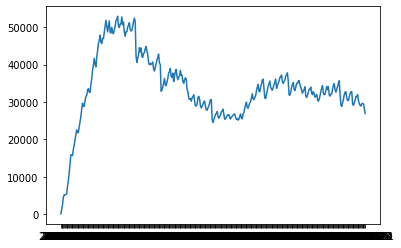

In [121]:
#plotting initial index
jobs = []
days = []
for i in range(0,len(columns)):
    jobs.append(columns[i][1])
    days.append(columns[i][0])
plt.plot(days,jobs)